## Code for reading raw data

In [63]:
import json 
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Define the function to read JSON folder by either giving a string parameter df or asking local input
def read_json_data(df=None):
    
    if df is None:
        # Ask for local input
        n = str(input("Enter the name of the dataset you would like to read (BRU/STO):" ))
    else:
        # Give a string-value to read for either BRU or STO
        n = df

    loc = os.path.join("data", "daily_production", n)
    
    data_list = []

    if os.path.exists(loc):
        # Iterate over each JSON file in the folder
        for filename in os.listdir(loc):
            if filename.endswith('.json'):
                file_path = os.path.join(loc, filename)
                
                # Read the JSON file
                with open(file_path, 'r') as file:
                    data = json.load(file)
                    
                # Append the data to data_list
                data_list.append(data)
        
        # Convert the list of dictionaries to a dataframe
        df = pd.DataFrame(data_list)
        
        return df
    else: 
        print(f"No data found for {n}. Please try again.")


df_factory = read_json_data()


## Define useful functions for data handling

In [97]:
from dateutil import parser

def convert_date(date_str): 
    return pd.to_datetime(date_str, format='%m-%d-%Y %H:%M:%S.%f')

def remove_rows_with_mv(dataframe):
    """
    Removes rows from a DataFrame where any column contains '#MV'.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: A new DataFrame with the specified rows removed.
    """
    # Replace '#MV' with NaN
    dataframe_cleaned = dataframe.replace('#MV', np.nan)

    # Drop rows with NaN values
    dataframe_cleaned = dataframe_cleaned.dropna()

    return dataframe_cleaned

def clean_data(data, exclude_zero=False):
    # Check if 'data' is a string (assumed to be a path to a JSON file)
    if isinstance(data, str):
        # Read the JSON file into a DataFrame
        dataframe = read_json_data(data)
    else:
        # Assume 'data' is already a DataFrame
        dataframe = pd.DataFrame(data)

    # Apply the 'remove_rows_with_mv' function
    dataframe = remove_rows_with_mv(dataframe)

    # Apply the 'no_zero' function if 'no_zero' is True
    if exclude_zero:
        dataframe = no_zero(dataframe)

    # Continue with the data cleaning operations
    dataframe['date'] = convert_date(dataframe['date'])
    dataframe['hour'] = pd.to_datetime(dataframe['hour'].astype(str), format='%H').dt.hour
    dataframe['minute'] = pd.to_datetime(dataframe['minute'].astype(str), format='%M').dt.minute
    dataframe['DoW'] = dataframe['DoW'].apply(lambda x: parser.parse(x).strftime("%A"))

    dataframe['prod_loss_perc'] = dataframe['prod_loss_perc'].astype(float)
    dataframe['prod_loss'] = dataframe['prod_loss'].astype(float)
    dataframe['production'] = dataframe['production'].astype(float)
    dataframe = dataframe.sort_values(by='date')
    dataframe = dataframe.reset_index(drop=True)

    return dataframe

def no_zero(dataframe):
    
    # Drop rows where production is equal to 0
    dataframe = dataframe[round(dataframe['production']) != 0]
    return dataframe

clean_data_factory = clean_data(df_factory, exclude_zero=True)
clean_data_factory.describe()



,hour,minute,date,prod_loss,prod_loss_perc,production
count,1428.0,1428.0,1428,1428.000000,1428.000000,1428.000000
mean,1.0,0.0,2020-08-28 03:16:38.319327744,254.781513,20.469188,989.218487
min,1.0,0.0,2018-01-01 00:00:00,51.000000,4.000000,348.000000
25%,1.0,0.0,2019-07-19 18:00:00,181.000000,15.000000,935.750000
50%,1.0,0.0,2020-09-08 12:00:00,242.000000,19.000000,1002.000000
75%,1.0,0.0,2021-11-05 06:00:00,308.250000,25.000000,1063.000000
max,1.0,0.0,2023-01-04 00:00:00,896.000000,72.000000,1193.000000
std,0.0,0.0,NaN,108.946056,8.764922,108.946056


## Write the restults to excel

In [ ]:
import pandas as pd

def save_to_excel():

    # Define the folder path to save the excel files
    folder_path = os.path.join("data")
    
    # Use earlier defined function to clean data
    json_raw = read_json_data()
    json_clean = clean_data(json_raw)

    # Write the clean DataFrame to an excel file
    json_clean.to_excel(os.path.join(folder_path, 'clean_data.xlsx'), index=False)

save_to_excel()

## Test data mean vs median with and without zero values

In [81]:

bru_with_zero = clean_data("BRU").copy()
sto_with_zero = clean_data("STO").copy()

bru_no_zero = no_zero(bru_with_zero)
sto_no_zero = no_zero(sto_with_zero)

# Calculate mean and median for both subsets
results = {
    "Location": ["Brussels", "Stockholm"],
    "Median with Zero": [bru_with_zero['production'].median(), sto_with_zero['production'].median()],
    "Median without Zero": [bru_no_zero['production'].median(), sto_no_zero['production'].median()],
    "Mean with Zero": [bru_with_zero['production'].mean(), sto_with_zero['production'].mean()],
    "Mean without Zero": [bru_no_zero['production'].mean(), sto_no_zero['production'].mean()]
}

# Create a DataFrame to display results
results_df = pd.DataFrame(results)

# Print the DataFrame in table format
print(results_df.to_string(index=False))



 Location  Median with Zero  Median without Zero  Mean with Zero  Mean without Zero
 Brussels             973.5               1002.0      813.711982         989.218487
Stockholm             201.0                202.0      176.945804         190.967925


## Function to plot data

In [ ]:
def plot_data():
    
    # Use earlier defined function to define data to be plotted
    df_raw= read_json_data()
    df_clean = clean_data(df_raw)
    # Check if 'Yes' values exist in the 'maintenance' column
    if 'Yes' in df_clean['maintenance'].values:
        # Create a new DataFrame excluding rows with 'maintenance' == 'Yes'
        dataframe_no_maintenance = df_clean[df_clean['maintenance'] != 'Yes']

        # Plot the new DataFrame
        dataframe_no_maintenance.plot(kind='bar', x='DoW', y='production', figsize=(12, 8))
    else:
        # Plot the original DataFrame
        df_clean.plot(kind='bar', x='DoW', y='production', figsize=(12, 8))

    # Add labels and title
    plt.ylabel('Production')
    plt.title('Production by Days of the Week')
    plt.xticks([])

    # Show plot
    plt.show()

plot_data()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract year and month
clean_data_factory['Year'] = clean_data_factory['date'].dt.year
clean_data_factory['Month'] = clean_data_factory['date'].dt.month

# Create a pivot table
pivot_table = clean_data_factory.pivot_table(values='production', index=['Year', 'Month'], aggfunc='sum')

# Flatten the pivot table index for easier plotting
pivot_table.reset_index(inplace=True)

# Create a new column for year-month
pivot_table['Year-Month'] = pivot_table.apply(lambda row: f"{int(row['Year'])}-{int(row['Month']):02d}", axis=1)

# Plot
plt.figure(figsize=(12, 8))
plt.plot(pivot_table['Year-Month'], pivot_table['production'], marker='o')
plt.xticks(rotation=45)
plt.ylabel('Total Production')
plt.title('Monthly Total Production Over Time')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Remove all rows where the df_bru.maintenance column has a value 'Yes'
df_bru_cleaned = df_bru[df_bru['maintenance'] != 'Yes'].copy()

# 2. Remove all NaN values
df_bru_cleaned.dropna(inplace=True)

# Convert 'date' to datetime if it's not already
df_bru_cleaned['date'] = pd.to_datetime(df_bru_cleaned['date'])

# Extract year and month
df_bru_cleaned['Year'] = df_bru_cleaned['date'].dt.year
df_bru_cleaned['Month'] = df_bru_cleaned['date'].dt.month

# Create a pivot table
pivot_table = df_bru_cleaned.pivot_table(values='production', index=['Year', 'Month'], aggfunc='mean')

# Flatten the pivot table index for easier plotting
pivot_table.reset_index(inplace=True)

# Create a new column for year-month
pivot_table['Year-Month'] = pivot_table.apply(lambda row: f"{int(row['Year'])}-{int(row['Month']):02d}", axis=1)

# 3. Plot
plt.figure(figsize=(12, 8))
plt.plot(pivot_table['Year-Month'], pivot_table['production'], marker='o')
plt.xticks(rotation=45)
plt.ylabel('Total Production')
plt.title('Monthly Total Production Over Time (After Cleaning)')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming `df_sto` is your DataFrame
# Remove rows with NaN values in either 'production' or 'prod_loss' columns
df_sto_clean = df_sto[df_sto['production'] > 0]
df_sto_clean = df_sto_clean.dropna(subset=['prod_loss'])

# Create a bar chart for 'production'
ax = df_sto_clean.plot(kind='bar', x='DoW', y='production', figsize=(12, 8), color='skyblue', label='Production')

# Create a line chart for 'prod_loss' on top of the bar chart
df_sto_clean.plot(kind='line', x='DoW', y='prod_loss', color='red',ax=ax, label='Production Loss')

# Optionally, you can hide the x-axis labels if they are not needed
ax.set_xticklabels([])  # Hides x-axis labels

# Set the labels and title
ax.set_xlabel('DoW')
ax.set_ylabel('Value')
ax.set_title('Production and Production Loss by Days of the Week')

# Add a legend to distinguish the two charts
ax.legend()

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming `df_bru` is your DataFrame
# Remove rows with NaN values in either 'production' or 'prod_loss' columns
df_bru_clean = df_bru[df_bru['production'] > 0]
df_bru_clean = df_bru_clean.dropna(subset=['prod_loss'])

# Create a bar chart for 'production'
ax = df_bru_clean.plot(kind='bar', x='DoW', y='production', color='skyblue', label='Production')

# Create a line chart for 'prod_loss' on top of the bar chart
df_bru_clean.plot(kind='line', x='DoW', y='prod_loss', color='red',ax=ax, label='Production Loss')

# Optionally, you can hide the x-axis labels if they are not needed
ax.set_xticklabels([])  # Hides x-axis labels

# Set the labels and title
ax.set_xlabel('DoW')
ax.set_ylabel('Value')
ax.set_title('Production and Production Loss by Days of the Week')

# Add a legend to distinguish the two charts
ax.legend()

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming `df_bru` is your DataFrame
# Remove rows with NaN values in either 'production' or 'prod_loss' columns
df_bru_clean = df_bru[df_bru['production'] > 0]
df_bru_clean = df_bru_clean.dropna(subset=['prod_loss'])

# Create a bar chart for 'production'
ax = df_bru_clean.plot(kind='line', x='DoW', y='production', color='skyblue', label='Production')

# Create a line chart for 'prod_loss' on top of the bar chart
df_bru_clean.plot(kind='line', x='DoW', y='prod_loss', color='red',ax=ax, label='Production Loss')

# Optionally, you can hide the x-axis labels if they are not needed
ax.set_xticklabels([])  # Hides x-axis labels

# Set the labels and title
ax.set_xlabel('DoW')
ax.set_ylabel('Value')
ax.set_title('Production and Production Loss by Days of the Week')

# Add a legend to distinguish the two charts
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Remove rows with NaN values in either 'production' or 'prod_loss' columns
df_sto_clean = df_sto[df_sto['production'] > 0]
df_sto_clean = df_sto_clean.dropna(subset=['prod_loss'])

# Create a bar chart for 'production'
ax = df_sto_clean.plot(kind='line', x='DoW', y='production', figsize=(12, 8), color='skyblue', label='Production')

# Create a line chart for 'prod_loss' on top of the bar chart
df_sto_clean.plot(kind='line', x='DoW', y='prod_loss', color='red',ax=ax, label='Production Loss')

# Optionally, you can hide the x-axis labels if they are not needed
ax.set_xticklabels([])  # Hides x-axis labels

# Set the labels and title
ax.set_xlabel('DoW')
ax.set_ylabel('Value')
ax.set_title('Production and Production Loss by Days of the Week')

# Add a legend to distinguish the two charts
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming `df_bru` is your DataFrame
# Remove rows with NaN values in either 'production' or 'prod_loss' columns
df_bru_clean = df_bru[df_bru['production'] > 0]
df_bru_clean = df_bru_clean.dropna(subset=['prod_loss'])

# Create the figure and the primary axis
fig, ax1 = plt.subplots(figsize=(12, 8))

# Create a line chart for 'production' on the primary axis
df_bru_clean.plot(kind='line', x='DoW', y='production', color='skyblue', label='Production', ax=ax1)

# Create a line chart for 'prod_loss' on the primary axis
df_bru_clean.plot(kind='line', x='DoW', y='prod_loss', color='red', ax=ax1, label='Production Loss')

# Set primary y-axis labels and title
ax1.set_xlabel('DoW')
ax1.set_ylabel('Value')
ax1.set_title('Production, Production Loss, and Production Loss Percentage by Days of the Week')

# Hide the x-axis labels to reduce clutter
ax1.set_xticklabels([])

# Create a secondary axis for the bar chart
ax2 = ax1.twinx()

# Create a bar chart for 'prod_loss_perc' on the secondary axis
df_bru_clean.plot(kind='bar', x='DoW', y='prod_loss_perc', color='green', ax=ax2, label='Production Loss %', alpha=0.5)

# Set secondary y-axis limit to 100% and label
ax2.set_ylim(0, 100)
ax2.set_ylabel('Production Loss %')

# Add legend for the primary axis
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add legend for the secondary axis
ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.85))

# Adjust layout
plt.tight_layout()

# Show the final plot
plt.show()


## Code for fitting distribution

/Users/gayk/anaconda3/envs/production/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6120: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/Users/gayk/anaconda3/envs/production/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/gayk/anaconda3/envs/production/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:1992: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)
/Users/gayk/anaconda3/envs/production/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:8280: RuntimeWarning: overflow encountered in divide
  s3 = (1/xm).sum()


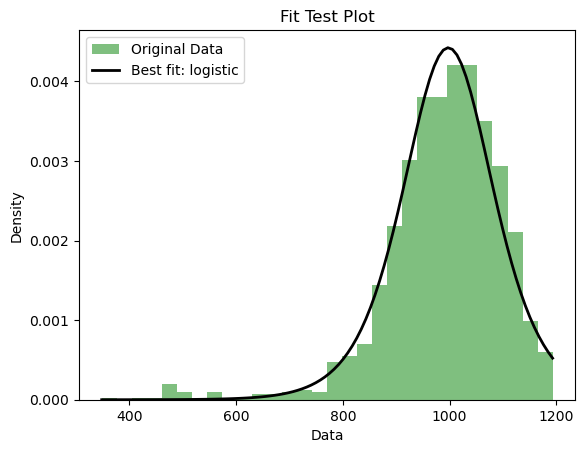

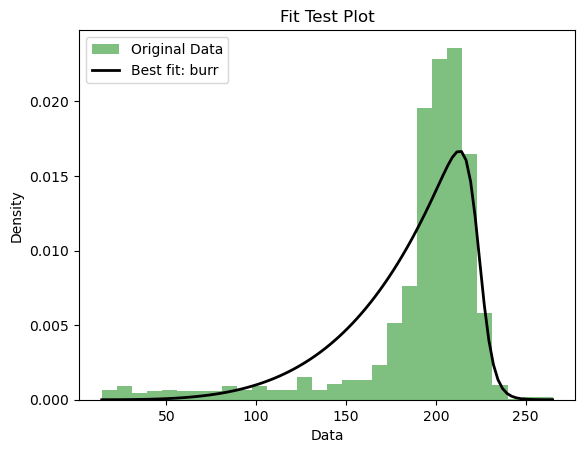

 Location Best-fit Distribution                                                   Parameters Best-fit Distribution without zero                                                         Parameters without zero
 Brussels           weibull_max (1.0820706975363437, 1193.0222300638648, 392.62319851694065)                           logistic                                          (997.4549009390882, 56.50299950611835)
Stockholm              logistic                     (191.28911031427484, 28.369291047308433)                               burr (56.15378627883318, 0.0861655653492476, -0.848774211561351, 224.57191980850808)


/Users/gayk/anaconda3/envs/production/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6120: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/Users/gayk/anaconda3/envs/production/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/gayk/anaconda3/envs/production/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:1992: RuntimeWarning: overflow encountered in divide
  place(output, cond, self._pdf(*goodargs) / scale)
/Users/gayk/anaconda3/envs/production/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:8280: RuntimeWarning: overflow encountered in divide
  s3 = (1/xm).sum()


Total Predicted Production for BRU (30 days): 25758.464335753306
Total Predicted Normal Production for BRU (30 days): 30162.333834319586


In [106]:
import numpy as np
from scipy import stats

def find_best_fit_distribution_continuous(data, distributions=None):
    """
    Find the best-fit distribution for the given data.

    Parameters:
        data (array-like): The data to fit the distributions to.
        distributions (list, optional): The candidate distributions to consider.
            Defaults to [stats.norm, stats.gamma, stats.expon, stats.uniform].

    Returns:
        best_distribution_bru (scipy.stats.rv_continuous): The best-fit distribution.
        best_params_bru (tuple): The parameters of the best-fit distribution.
    """
    if distributions is None:
        if distributions is None:
            distributions = [
                stats.norm,          # Normal distribution
                stats.gamma,         # Gamma distribution
                stats.expon,         # Exponential distribution
                stats.uniform,       # Uniform distribution
                stats.lognorm,       # Log-Normal distribution
                stats.t,             # Student's T distribution
                stats.logistic,      # Logistic distribution
                stats.rayleigh,      # Rayleigh distribution
                stats.weibull_min,   # Weibull minimum distribution
                stats.weibull_max,   # Weibull maximum distribution
                stats.burr           # Burr distribution
            ]

    best_distribution = None
    best_params = {}
    best_sse = np.inf

    for distribution in distributions:
        params = distribution.fit(data)
        sse = np.sum((distribution.pdf(data, *params) - data) ** 2)

        if sse < best_sse:
            best_distribution = distribution
            best_params = params
            best_sse = sse

    return best_distribution, best_params

def fit_test_plot(original_data, best_distribution, best_params):
    # Create a histogram of the original data
    plt.hist(original_data, bins=30, density=True, alpha=0.5, color='g', label='Original Data')

    # Generate a range of values for plotting the distribution
    xmin, xmax = min(original_data), max(original_data)
    x = np.linspace(xmin, xmax, 100)

    # Calculate the PDF of the best-fit distribution and plot it
    y = best_distribution.pdf(x, *best_params)
    plt.plot(x, y, 'k', linewidth=2, label=f'Best fit: {best_distribution.name}')

    # Set the title and labels
    plt.title('Fit Test Plot')
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.legend()

    # Show the plot
    plt.show()
    
def simulation(days, factory, distribution=None, params=None, normal_production=False):
    # Check if distribution and parameters are provided
    if distribution is None or params is None:
        # Load and clean the factory data
        if normal_production:
            # Exclude zero values in production
            data = clean_data(factory, exclude_zero=True)
        else:
            # Include all data, including zero values
            data = clean_data(factory)

        # Find the best-fit distribution and parameters
        distribution, params = find_best_fit_distribution_continuous(data.production)

    # Generate random samples from the distribution
    simulated_production = distribution.rvs(*params, size=days)

    # Sum the production over the given days to get total production
    total_production = np.sum(simulated_production)

    return total_production

    

def main():
    # Generate sample data
    np.random.seed(0)
    values = np.random.normal(loc=939, scale=1, size=1000)
    
    data_bru = clean_data("BRU")
    data_sto = clean_data("STO")

    # Find the best-fit distribution for original data
    best_distribution_bru, best_params_bru = find_best_fit_distribution_continuous(data_bru.production)
    best_distribution_sto, best_params_sto = find_best_fit_distribution_continuous(data_sto.production)

    # Find the best-fit distribution for data without zeros to test our distribution fit with zeros included
    data_bru_no_zero = clean_data("BRU", exclude_zero=True)
    data_sto_no_zero = clean_data("STO", exclude_zero=True)
    best_distribution_bru_no_zero, best_params_bru_no_zero = find_best_fit_distribution_continuous(data_bru_no_zero.production)
    best_distribution_sto_no_zero, best_params_sto_no_zero = find_best_fit_distribution_continuous(data_sto_no_zero.production)
    
    # Fit and plot for Brussels without zeros
    fit_test_plot(data_bru_no_zero.production, best_distribution_bru_no_zero, best_params_bru_no_zero)

    # Fit and plot for Stockholm without zeros
    fit_test_plot(data_sto_no_zero.production, best_distribution_sto_no_zero, best_params_sto_no_zero)


    # Create a DataFrame for displaying results in a table format
    results_df = pd.DataFrame({
        "Location": ["Brussels", "Stockholm"],
        "Best-fit Distribution": [best_distribution_bru.name, best_distribution_sto.name],
        "Parameters": [best_params_bru, best_params_sto],
        "Best-fit Distribution without zero": [best_distribution_bru_no_zero.name, best_distribution_sto_no_zero.name],
        "Parameters without zero": [best_params_bru_no_zero, best_params_sto_no_zero]
    })

    # Print the DataFrame
    print(results_df.to_string(index=False))
    
    # Total MSR on full production days
    total_prod_bru = simulation(30, 'BRU')  # Predict total production for 30 days for BRU factory
    print(f"Total Predicted Full Production for BRU (30 days): {total_prod_bru}")
    
    # Predict total production for 30 days for BRU factory with normal production
    total_prod_bru_normal = simulation(30, 'BRU', normal_production=True)  
    print(f"Total Predicted Normal Production for BRU (30 days): {total_prod_bru_normal}")


if __name__ == '__main__':
    main()

## Define a simulation function to predict the output of given days


In [114]:
import numpy as np
from scipy import stats
import warnings 

def find_best_fit_distribution_continuous(data, distributions=None):
    """
    Find the best-fit distribution for the given data.

    Parameters:
        data (array-like): The data to fit the distributions to.
        distributions (list, optional): The candidate distributions to consider.
            Defaults to [stats.norm, stats.gamma, stats.expon, stats.uniform].

    Returns:
        best_distribution_bru (scipy.stats.rv_continuous): The best-fit distribution.
        best_params_bru (tuple): The parameters of the best-fit distribution.
    """
    if distributions is None:
        distributions = [
            stats.norm,          # Normal distribution
            stats.gamma,         # Gamma distribution
            stats.expon,         # Exponential distribution
            stats.uniform,       # Uniform distribution
            stats.lognorm,       # Log-Normal distribution
            stats.t,             # Student's T distribution
            stats.logistic,      # Logistic distribution
            stats.rayleigh,      # Rayleigh distribution
            stats.weibull_min,   # Weibull minimum distribution
            stats.weibull_max,   # Weibull maximum distribution
            stats.burr           # Burr distribution
        ]

    best_distribution = None
    best_params = {}
    best_sse = np.inf

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        
        for distribution in distributions:
            try:
                params = distribution.fit(data)
                sse = np.sum((distribution.pdf(data, *params) - data) ** 2)

                if sse < best_sse:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

            except Exception as e:
                print(f"An exception occurred for distribution {distribution.name}: {e}")

    return best_distribution, best_params
    



## Code for simulating the outcomes

In [ ]:
def simulation(days, factory, distribution=None, params=None, normal_production=False):
    # Check if distribution and parameters are provided
    if distribution is None or params is None:
        # Load and clean the factory data
        if normal_production:
            # Exclude zero values in production
            data = clean_data(factory, exclude_zero=True)
        else:
            # Include all data, including zero values
            data = clean_data(factory)

        # Find the best-fit distribution and parameters
        distribution, params = find_best_fit_distribution_continuous(data.production)

    # Generate random samples from the distribution
    simulated_production = distribution.rvs(*params, size=days)

    # Sum the production over the given days to get total production
    total_production = np.sum(simulated_production)

    return total_production

## Code for plotting the original data versus the outcome of the distribution fit

In [ ]:
def fit_test_plot(original_data, best_distribution, best_params):
    # Create a histogram of the original data
    plt.hist(original_data, bins=30, density=True, alpha=0.5, color='g', label='Original Data')

    # Generate a range of values for plotting the distribution
    xmin, xmax = min(original_data), max(original_data)
    x = np.linspace(xmin, xmax, 100)

    # Calculate the PDF of the best-fit distribution and plot it
    y = best_distribution.pdf(x, *best_params)
    plt.plot(x, y, 'k', linewidth=2, label=f'Best fit: {best_distribution.name}')

    # Set the title and labels
    plt.title('Fit Test Plot')
    plt.xlabel('Data')
    plt.ylabel('Density')
    plt.legend()

    # Show the plot
    plt.show()

## Main code to try everything out (let's hope for the best)

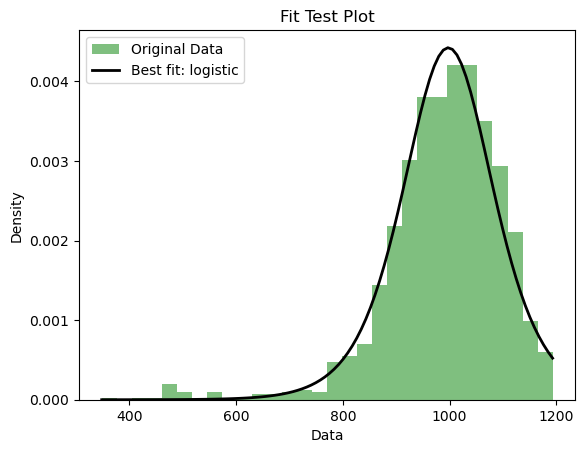

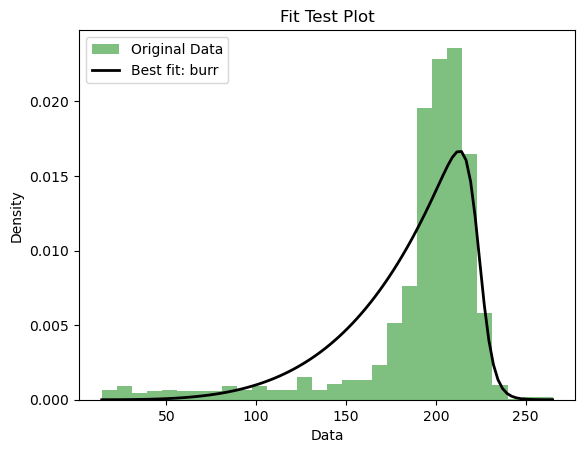

,Location,Best-fit Distribution,Parameters,Best-fit Distribution without zero,Parameters without zero
0,Brussels,weibull_max,"(1.0820706975363437, 1193.0222300638648, 392.6...",logistic,"(997.4549009390882, 56.50299950611835)"
1,Stockholm,logistic,"(191.28911031427484, 28.369291047308433)",burr,"(56.15378627883318, 0.0861655653492476, -0.848..."


    
Total Predicted Full Production for BRU (30 days): 25758.464335753306
    
Total Predicted Normal Production for BRU (30 days): 30162.333834319586


In [120]:

# Generate sample data
np.random.seed(0)
values = np.random.normal(loc=939, scale=1, size=1000)

data_bru = clean_data("BRU")
data_sto = clean_data("STO")

# Find the best-fit distribution for original data
best_distribution_bru, best_params_bru = find_best_fit_distribution_continuous(data_bru.production)
best_distribution_sto, best_params_sto = find_best_fit_distribution_continuous(data_sto.production)

# Find the best-fit distribution for data without zeros to test our distribution fit with zeros included
data_bru_no_zero = clean_data("BRU", exclude_zero=True)
data_sto_no_zero = clean_data("STO", exclude_zero=True)
best_distribution_bru_no_zero, best_params_bru_no_zero = find_best_fit_distribution_continuous(data_bru_no_zero.production)
best_distribution_sto_no_zero, best_params_sto_no_zero = find_best_fit_distribution_continuous(data_sto_no_zero.production)

# Fit and plot for Brussels without zeros
fit_test_plot(data_bru_no_zero.production, best_distribution_bru_no_zero, best_params_bru_no_zero)

# Fit and plot for Stockholm without zeros
fit_test_plot(data_sto_no_zero.production, best_distribution_sto_no_zero, best_params_sto_no_zero)


# Create a DataFrame for displaying results in a table format
results_df = pd.DataFrame({
    "Location": ["Brussels", "Stockholm"],
    "Best-fit Distribution": [best_distribution_bru.name, best_distribution_sto.name],
    "Parameters": [best_params_bru, best_params_sto],
    "Best-fit Distribution without zero": [best_distribution_bru_no_zero.name, best_distribution_sto_no_zero.name],
    "Parameters without zero": [best_params_bru_no_zero, best_params_sto_no_zero]
})

# Display the DataFrame
display(results_df)

print("\
    ")

# Total MSR on full production days
total_prod_bru = simulation(30, 'BRU')  # Predict total production for 30 days for BRU factory
print(f"Total Predicted Full Production for BRU (30 days): {total_prod_bru}")

print("\
    ")
# Predict total production for 30 days for BRU factory with normal production
total_prod_bru_normal = simulation(30, 'BRU', normal_production=True)  
print(f"Total Predicted Normal Production for BRU (30 days): {total_prod_bru_normal}")